# Preprocessing

In [1]:
# Import dependencies

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import psycopg2

In [2]:
# Create connection to database
endpoint='superstoredb.c9p2luakmclc.us-east-2.rds.amazonaws.com'

connection = psycopg2.connect(
    host = endpoint,
    port = 5432,
    user = 'postgres',
    password = 'superstore',
    database='SuperstoreDB'
    )
cursor=connection.cursor()

OperationalError: could not connect to server: Connection timed out (0x0000274C/10060)
	Is the server running on host "superstoredb.c9p2luakmclc.us-east-2.rds.amazonaws.com" (13.59.228.34) and accepting
	TCP/IP connections on port 5432?


In [3]:
# Import CSV (must be through a database conection)

file_path='Data/globalsuperstore.csv'
superstore_df=pd.read_csv(file_path)
superstore_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31/07/2012,31/07/2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05/02/2013,07/02/2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17/10/2013,18/10/2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,28/01/2013,30/01/2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,05/11/2013,06/11/2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


In [4]:
# Look at the data types of the df
superstore_df.dtypes

Row ID              int64
Order ID           object
Order Date         object
Ship Date          object
Ship Mode          object
Customer ID        object
Customer Name      object
Segment            object
City               object
State              object
Country            object
Postal Code       float64
Market             object
Region             object
Product ID         object
Category           object
Sub-Category       object
Product Name       object
Sales             float64
Quantity            int64
Discount          float64
Profit            float64
Shipping Cost     float64
Order Priority     object
dtype: object

In [5]:
# Modify datatypes of Order and Ship Date to datetime

superstore_df['Order Date']=pd.to_datetime(superstore_df['Order Date'])
superstore_df['Ship Date']=pd.to_datetime(superstore_df['Ship Date'])
superstore_df.dtypes

Row ID                     int64
Order ID                  object
Order Date        datetime64[ns]
Ship Date         datetime64[ns]
Ship Mode                 object
Customer ID               object
Customer Name             object
Segment                   object
City                      object
State                     object
Country                   object
Postal Code              float64
Market                    object
Region                    object
Product ID                object
Category                  object
Sub-Category              object
Product Name              object
Sales                    float64
Quantity                   int64
Discount                 float64
Profit                   float64
Shipping Cost            float64
Order Priority            object
dtype: object

In [6]:
#Get day of the week from Order Date column (0=monday - 6=Sunday)

superstore_df['Day of the week']=pd.DatetimeIndex(superstore_df['Order Date']).dayofweek
superstore_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Day of the week
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,1
1,26341,IN-2013-77878,2013-05-02,2013-07-02,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,3
2,25330,IN-2013-71249,2013-10-17,2013-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,3
3,13524,ES-2013-1579342,2013-01-28,2013-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium,0
4,47221,SG-2013-4320,2013-05-11,2013-06-11,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,5


In [7]:
#Get month from Order Date column (1=january - 12=December)

superstore_df['Month_number']=pd.DatetimeIndex(superstore_df['Order Date']).month
superstore_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Day of the week,Month_number
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,1,7
1,26341,IN-2013-77878,2013-05-02,2013-07-02,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,3,5
2,25330,IN-2013-71249,2013-10-17,2013-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,3,10
3,13524,ES-2013-1579342,2013-01-28,2013-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium,0,1
4,47221,SG-2013-4320,2013-05-11,2013-06-11,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,5,5


In [8]:
#Classify rows into profitable (1) and non-profitable (0)

superstore_df['Profit Classification']= np.where(superstore_df['Profit']<=0, 0, 1)
superstore_df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Day of the week,Month_number,Profit Classification
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,1,7,1
1,26341,IN-2013-77878,2013-05-02,2013-07-02,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,3,5,0
2,25330,IN-2013-71249,2013-10-17,2013-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,3,10,1
3,13524,ES-2013-1579342,2013-01-28,2013-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium,0,1,0
4,47221,SG-2013-4320,2013-05-11,2013-06-11,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,29002,IN-2014-62366,2014-06-19,2014-06-19,Same Day,KE-16420,Katrina Edelman,Corporate,Kure,Hiroshima,...,"Advantus Thumb Tacks, 12 Pack",65.100,5,0.0,4.5000,0.01,Medium,3,6,1
51286,35398,US-2014-102288,2014-06-20,2014-06-24,Standard Class,ZC-21910,Zuschuss Carroll,Consumer,Houston,Texas,...,Hoover Replacement Belt for Commercial Guardsm...,0.444,1,0.8,-1.1100,0.01,Medium,4,6,0
51287,40470,US-2013-155768,2013-02-12,2013-02-12,Same Day,LB-16795,Laurel Beltran,Home Office,Oxnard,California,...,"#10- 4 1/8"" x 9 1/2"" Security-Tint Envelopes",22.920,3,0.0,11.2308,0.01,High,1,2,1
51288,9596,MX-2012-140767,2012-02-18,2012-02-22,Standard Class,RB-19795,Ross Baird,Home Office,Valinhos,S�o Paulo,...,"Acco Index Tab, Economy",13.440,2,0.0,2.4000,0.00,Medium,5,2,1


In [42]:
# Order Dataframe by order date
superstore_df=superstore_df.sort_values('Order Date',ascending=True)
superstore_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Day of the week,Month_number,Profit Classification
9352,42433,AG-2011-2040,2011-01-01,2011-06-01,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,...,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium,5,1,1
42055,22254,IN-2011-47883,2011-01-01,2011-08-01,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,"Eaton Computer Printout Paper, 8.5 x 11",55.242,2,0.1,15.342,1.80,Medium,5,1,1
22951,22253,IN-2011-47883,2011-01-01,2011-08-01,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium,5,1,1
31869,22255,IN-2011-47883,2011-01-01,2011-08-01,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium,5,1,1
31579,11731,IT-2011-3647632,2011-01-01,2011-05-01,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,...,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High,5,1,0


# Exploration

In [10]:
#Create table to see sales per day
sales_perday_df=superstore_df.groupby(['Day of the week']).sum()
sales_perday_df=sales_perday_df.drop(columns=['Row ID','Postal Code','Profit Classification','Month_number'])
sales_perday_df=sales_perday_df.reset_index()
sales_perday_df

,Day of the week,Sales,Quantity,Discount,Profit,Shipping Cost
0,0,2.067053e+06,29410,1218.306,246526.55710,215410.54
1,1,2.150076e+06,30055,1223.606,249788.05098,232012.33
2,2,1.954614e+06,28497,1215.698,205552.30862,211597.91
3,3,2.057502e+06,29118,1180.026,241183.07994,226233.32
4,4,2.144812e+06,30321,1256.196,243802.83544,224659.92
5,5,1.433806e+06,19620,791.856,176486.55222,156899.52
6,6,8.346382e+05,11291,444.040,104117.90698,86007.15


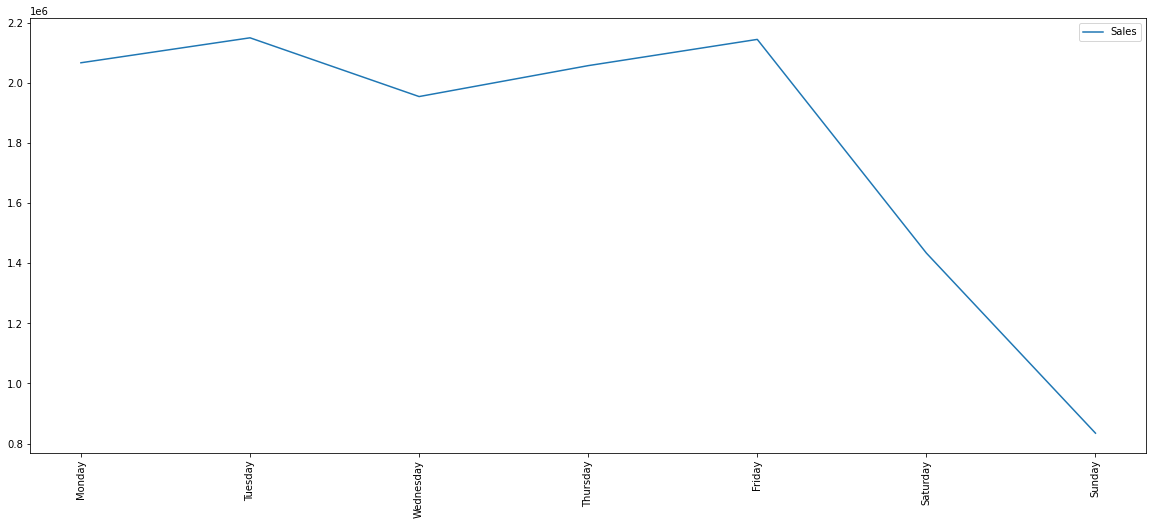

In [11]:
fig=plt.figure(figsize=(20,8))
plot=sales_perday_df['Sales'].plot(legend='Sales')
labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.xticks(sales_perday_df['Day of the week'],labels,rotation=90)
plt.show()

In [12]:
#Create table to see sales per month
month_df=superstore_df.groupby(['Month_number']).sum()
month_df=month_df.drop(columns=['Row ID','Postal Code','Profit Classification','Day of the week'])
month_df=month_df.reset_index()
month_df

,Month_number,Sales,Quantity,Discount,Profit,Shipping Cost
0,1,7.757669e+05,10750,445.666,90584.80272,82583.39
1,2,7.228532e+05,9935,412.118,96425.03602,76279.02
2,3,9.513331e+05,13013,541.084,123893.00142,97644.13
3,4,8.516173e+05,12245,506.756,95927.05920,89799.13
4,5,9.764157e+05,13826,556.782,111031.76714,107736.05
5,6,1.152368e+06,16699,691.576,144458.78866,124187.56
6,7,8.387436e+05,12278,512.840,85827.65364,94657.08
7,8,1.247501e+06,16430,676.784,135583.35630,128815.75
8,9,1.244140e+06,17917,736.174,128737.11324,132777.60
9,10,1.120777e+06,15906,626.676,138733.88830,119367.95


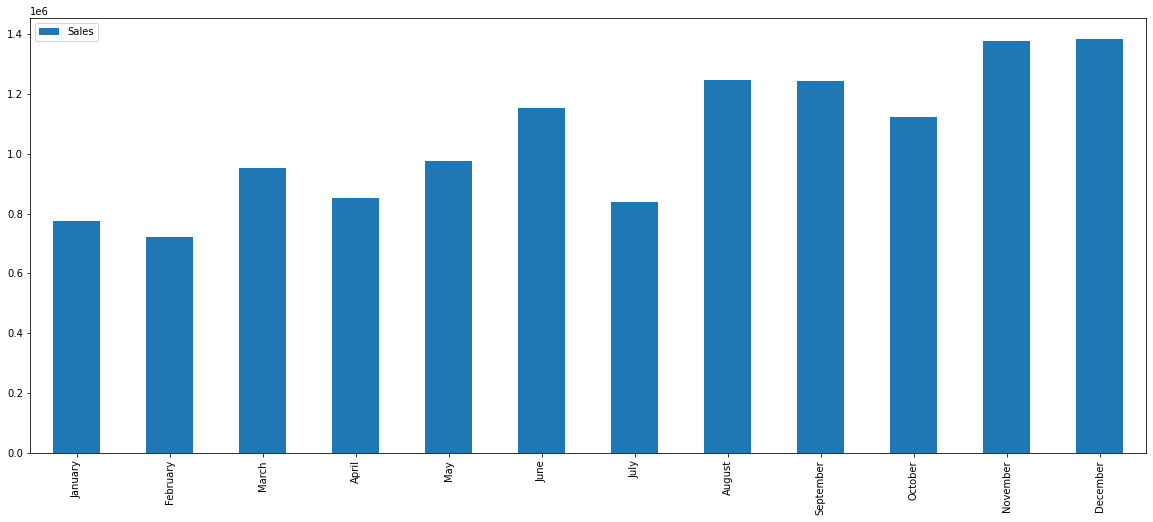

In [13]:
fig=plt.figure(figsize=(20,8))
plot=month_df['Sales'].plot(legend='Sales',kind='bar')
labels=['January','February','March','April','May','June','July','August','September','October','November','December']
plt.xticks(month_df['Month_number']-1,labels,rotation=90)
plt.show()

In [14]:
#Create table to see sales per day
sales_percategory_df=superstore_df.groupby(['Category','Day of the week']).sum()
sales_percategory_df=sales_percategory_df.drop(columns=['Row ID','Postal Code','Profit Classification','Month_number','Discount'])
sales_percategory_df=sales_percategory_df.reset_index()
sales_percategory_df

,Category,Day of the week,Sales,Quantity,Profit,Shipping Cost
0,Furniture,0,667354.12620,5794,38156.40910,70990.93
1,Furniture,1,667205.94660,5741,53217.54030,71613.83
2,Furniture,2,637413.85420,5506,34862.16080,68757.20
3,Furniture,3,637867.52420,5395,48058.76260,67365.38
4,Furniture,4,735190.79980,6243,47319.68100,77254.99
5,Furniture,5,498366.84330,4090,42536.09270,57027.60
6,Furniture,6,267475.09200,2185,21054.07730,27310.73
7,Office Supplies,0,600442.19260,17742,77672.38630,62885.82
8,Office Supplies,1,650677.57440,18144,87586.20510,69445.07
9,Office Supplies,2,604594.59890,17421,80153.86700,64891.62


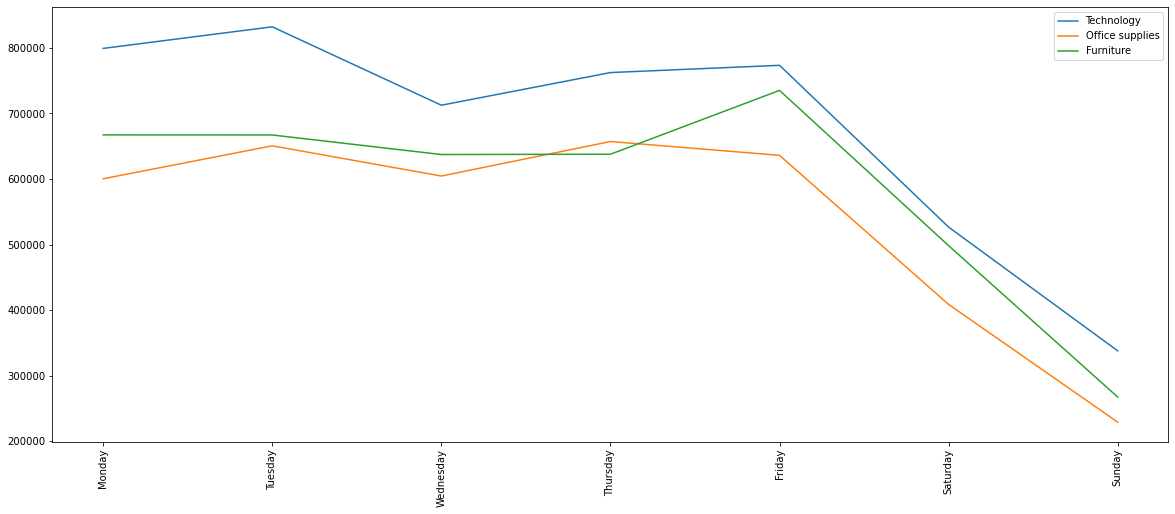

In [15]:
fig=plt.figure(figsize=(20,8))
x1=sales_percategory_df['Sales'][sales_percategory_df['Category']=='Technology']
x2=sales_percategory_df['Sales'][sales_percategory_df['Category']=='Office Supplies']
x3=sales_percategory_df['Sales'][sales_percategory_df['Category']=='Furniture']
y=sales_percategory_df['Day of the week'].value_counts().index
plot1=plt.plot(y,x1,label='Technology')

plot2=plt.plot(y,x2,label='Office supplies')

plot3=plt.plot(y,x3,label='Furniture')

plt.legend()

labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.xticks(y,labels,rotation=90)
plt.show()

# Transform data to fit into Machine Learning Model

In [16]:
# Drop unnecesary columns

superstore_ML_df=superstore_df.drop(columns=['Row ID',
                                          'Order ID',
                                          'Customer ID',
                                          'Customer Name',
                                          'Postal Code',
                                          'Product ID',
                                          'Product Name',
                                          'Ship Date',
                                          'City',
                                          'State',
                                          'Country',
                                          'Order Date',
                                          'Sub-Category',
                                          'Market',
                                          'Profit'
                                         ])
superstore_ML_df.head()

,Ship Mode,Segment,Region,Category,Sales,Quantity,Discount,Shipping Cost,Order Priority,Day of the week,Month_number,Profit Classification
42055,Standard Class,Consumer,Oceania,Office Supplies,55.242,2,0.1,1.80,Medium,5,1,1
25084,Second Class,Consumer,EMEA,Office Supplies,66.120,4,0.0,8.17,High,5,1,1
31869,Standard Class,Consumer,Oceania,Furniture,113.670,5,0.1,4.70,Medium,5,1,1
22951,Standard Class,Consumer,Oceania,Office Supplies,120.366,3,0.1,9.72,Medium,5,1,1
31579,Second Class,Home Office,North,Office Supplies,44.865,3,0.5,4.82,High,5,1,0


In [17]:
superstore_categories = superstore_ML_df.dtypes[superstore_ML_df.dtypes == "object"].index.tolist()
superstore_categories

['Ship Mode', 'Segment', 'Region', 'Category', 'Order Priority']

In [18]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(superstore_ML_df[superstore_categories]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(superstore_categories)
encode_df.head()

,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Region_Africa,Region_Canada,Region_Caribbean,...,Region_South,Region_Southeast Asia,Region_West,Category_Furniture,Category_Office Supplies,Category_Technology,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [19]:
# Merge one-hot encoded features and drop the originals
superstore_ML_df = superstore_ML_df.merge(encode_df,left_index=True, right_index=True)
superstore_ML_df = superstore_ML_df.drop(superstore_categories,1)
superstore_ML_df.head()

,Sales,Quantity,Discount,Shipping Cost,Day of the week,Month_number,Profit Classification,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,...,Region_South,Region_Southeast Asia,Region_West,Category_Furniture,Category_Office Supplies,Category_Technology,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium
42055,55.242,2,0.1,1.80,5,1,1,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
25084,66.120,4,0.0,8.17,5,1,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
31869,113.670,5,0.1,4.70,5,1,1,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
22951,120.366,3,0.1,9.72,5,1,1,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
31579,44.865,3,0.5,4.82,5,1,0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
corr_matrix=superstore_df.corr()

In [43]:
corr_matrix['Sales'].sort_values()

Discount                -0.086722
Row ID                  -0.043889
Postal Code             -0.023854
Month_number            -0.000260
Day of the week          0.003400
Profit Classification    0.056138
Quantity                 0.313577
Profit                   0.484918
Shipping Cost            0.768073
Sales                    1.000000
Name: Sales, dtype: float64

In [45]:
corr_matrix['Sales'].sort_values().index

Index(['Discount', 'Row ID', 'Postal Code', 'Month_number', 'Day of the week',
       'Profit Classification', 'Quantity', 'Profit', 'Shipping Cost',
       'Sales'],
      dtype='object')

In [22]:
from pandas.plotting import scatter_matrix

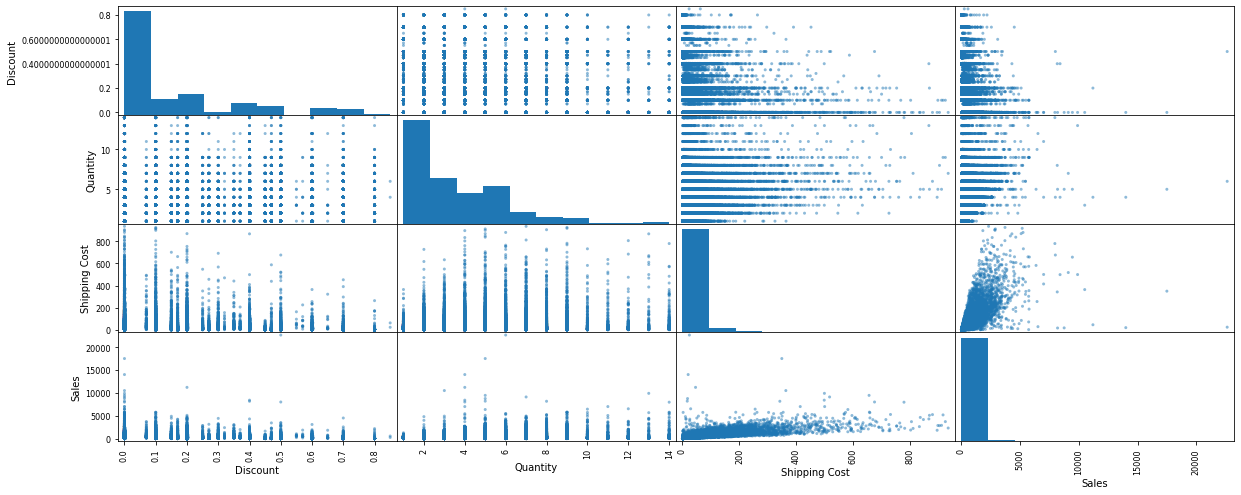

In [49]:
attributes=['Discount','Quantity','Shipping Cost','Sales']
scatter_matrix(superstore_df[attributes],figsize=(20,8))
plt.show()

In [24]:
#Chose independent variables

X=superstore_ML_df.copy()
X=superstore_ML_df.drop(columns=['Profit Classification'])
X.head()

,Sales,Quantity,Discount,Shipping Cost,Day of the week,Month_number,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,...,Region_South,Region_Southeast Asia,Region_West,Category_Furniture,Category_Office Supplies,Category_Technology,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium
42055,55.242,2,0.1,1.80,5,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
25084,66.120,4,0.0,8.17,5,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
31869,113.670,5,0.1,4.70,5,1,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
22951,120.366,3,0.1,9.72,5,1,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
31579,44.865,3,0.5,4.82,5,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
#Chose dependent variables
y=superstore_ML_df['Profit Classification']
y

42055    1
25084    1
31869    1
22951    1
31579    0
        ..
7907     0
6607     1
35415    0
7117     1
18939    0
Name: Profit Classification, Length: 51290, dtype: int32

# Train and test Machine learning

In [26]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=25)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Gradient Boosting

In [27]:
# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    classifier = GradientBoostingClassifier(n_estimators=25,
                                            learning_rate=learning_rate,
                                            max_features=5,
                                            max_depth=3,
                                            random_state=25)
    # Fit the model
    classifier.fit(X_train_scaled, y_train)
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        classifier.score(
            X_train_scaled,
            y_train)))
    print("Accuracy score (validation): {0:.3f}".format(
        classifier.score(
            X_test_scaled,
            y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.866
Accuracy score (validation): 0.862

Learning rate:  0.1
Accuracy score (training): 0.920
Accuracy score (validation): 0.919

Learning rate:  0.25
Accuracy score (training): 0.921
Accuracy score (validation): 0.919

Learning rate:  0.5
Accuracy score (training): 0.920
Accuracy score (validation): 0.920

Learning rate:  0.75
Accuracy score (training): 0.920
Accuracy score (validation): 0.920

Learning rate:  1
Accuracy score (training): 0.920
Accuracy score (validation): 0.917



In [28]:
# Choose a learning rate and create classifier
classifier = GradientBoostingClassifier(n_estimators=25,
                                        learning_rate=0.75,
                                        max_features=5,
                                        max_depth=3,
                                        random_state=25)

# Fit the model
classifier.fit(X_train_scaled, y_train)

# Make Prediction
predictions = classifier.predict(X_test_scaled)
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).head(20)

,Prediction,Actual
18390,1,1
13213,1,0
22954,1,1
40319,1,1
6576,1,1
25688,1,1
17864,1,1
9998,1,1
44439,1,1
29085,1,1


In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.9198315526787804


In [30]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual non-Profit", "Actual Profit"],
    columns=["Predicted non-Profit", "Predicted Profit"]
)

# Displaying results
display(cm_df)

,Predicted non-Profit,Predicted Profit
Actual non-Profit,2535,758
Actual Profit,270,9260


In [31]:
# Generate classification report
print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      3293
           1       0.92      0.97      0.95      9530

    accuracy                           0.92     12823
   macro avg       0.91      0.87      0.89     12823
weighted avg       0.92      0.92      0.92     12823



In [32]:
# Importance of features
importances=classifier.feature_importances_
importances

array([7.19650248e-02, 3.71772830e-03, 9.06687927e-01, 1.31739970e-02,
       3.00828581e-04, 4.42704401e-04, 7.82997064e-05, 3.54768353e-05,
       8.54145479e-05, 1.10175979e-04, 5.86295723e-05, 2.31223222e-05,
       1.16996260e-04, 4.57452207e-05, 5.33528672e-05, 4.57044481e-05,
       4.85903999e-05, 1.56331722e-04, 4.51611983e-05, 5.13909804e-06,
       2.17149798e-04, 1.24176784e-05, 2.07086993e-05, 2.45180373e-04,
       1.45912371e-04, 9.45823006e-05, 3.33285010e-04, 1.14623870e-03,
       1.11214595e-04, 5.73104846e-05, 3.43081320e-05, 8.74958103e-05,
       2.97845854e-04])

In [33]:
sorted(zip(classifier.feature_importances_, X.columns), reverse=True)

[(0.9066879268679167, 'Discount'),
 (0.07196502483526739, 'Sales'),
 (0.013173997031385165, 'Shipping Cost'),
 (0.003717728302714134, 'Quantity'),
 (0.001146238697088144, 'Category_Office Supplies'),
 (0.00044270440058229063, 'Month_number'),
 (0.0003332850095991684, 'Category_Furniture'),
 (0.0003008285814970331, 'Day of the week'),
 (0.0002978458543602402, 'Order Priority_Medium'),
 (0.0002451803732586096, 'Region_South'),
 (0.00021714979799760336, 'Region_North'),
 (0.0001563317222177967, 'Region_Central Asia'),
 (0.00014591237086106383, 'Region_Southeast Asia'),
 (0.00011699625956481988, 'Segment_Home Office'),
 (0.00011121459518776112, 'Category_Technology'),
 (0.00011017597880179487, 'Ship Mode_Standard Class'),
 (9.458230058797733e-05, 'Region_West'),
 (8.749581028619631e-05, 'Order Priority_Low'),
 (8.54145478582904e-05, 'Ship Mode_Second Class'),
 (7.829970642952324e-05, 'Ship Mode_First Class'),
 (5.862957234210506e-05, 'Segment_Consumer'),
 (5.7310484631350924e-05, 'Order Pr

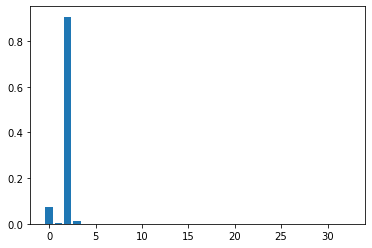

In [34]:
# plot
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

# Random Forest

In [ ]:
# Create random forest classifier
rf_model=RandomForestClassifier(n_estimators=1000,random_state=25)

In [ ]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [ ]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test)
predictions

In [ ]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

In [ ]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

In [ ]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
importances

In [ ]:
# We can sort the features by their importance.
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=25)

In [ ]:
classifier.fit(X_train_scaled, y_train)

In [ ]:
y_pred = classifier.predict(X_test_scaled)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(20)

In [ ]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

In [ ]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, y_pred)
print(acc_score)

In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))

# Linear regression

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le=LabelEncoder()
superstore_df_le=superstore_df.copy()
superstore_df_le

In [ ]:

superstore_df_le=superstore_df.drop(columns=['Row ID',
                                          'Order ID',
                                          'Customer ID',
                                          'Customer Name',
                                          'Postal Code',
                                          'Product ID',
                                          'Product Name',
                                          'Ship Date',
                                          'City',
                                          'State',
                                          'Country',
                                          'Order Date',
                                          'Sub-Category',
                                          'Market',
                                          'Profit'
                                         ])
superstore_df_le.head()

In [ ]:
sle_categories = superstore_df_le.dtypes[superstore_df_le.dtypes == "object"].index.tolist()
sle_categories

In [ ]:
for i in sle_categories:
    superstore_df_le[i]=le.fit_transform(superstore_df_le[i])
superstore_df_le

In [ ]:
X=superstore_df_le.copy()
X=X.drop(columns=['Sales','Profit Classification'])
X

In [ ]:
y=superstore_df_le['Sales']
y

In [ ]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=25)

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [ ]:
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

In [ ]:
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Use our model to predict a value
predicted = model.predict(X)

# Score the prediction with MSE and R2
mse = mean_squared_error(y, predicted)
r2 = r2_score(y, predicted)

print(f"mean squared error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")